In [1]:
# Run if you are executing this notebook in Colab to ensure tf v2.x.x
!pip install -U tensorflow keras

Requirement already up-to-date: tensorflow in c:\users\d074009\appdata\local\programs\python\python37\lib\site-packages (2.0.0)
Requirement already up-to-date: keras in c:\users\d074009\appdata\local\programs\python\python37\lib\site-packages (2.3.1)


In [2]:
import datetime
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import models, layers, datasets
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# A SF Permits Cleaning

### Methode um Y/NaN Spalten zu konvertieren

In [4]:
def replace_y_with_0_1(df: pd.DataFrame, column: str):
    """
    Ersetzt Y und leere Felder in Spalten die nur Y und leere Felder erhalten durch 1 und 0 
    :param df: Dataframe in dem sich die Spalten befinden
    :param column: Name der Spalte in der die Werte ersetzt werden sollen
    :return: DataFrame mit modifizierten Spalten
    """
    df[column].fillna(0, inplace=True)
    df[column].replace('Y', 1, inplace=True)

### Datenset in ein Dataframe laden laden und Vorschau anzeigen

In [5]:
sanfrancisco_df = pd.read_csv("./building_permits.csv")

sanfrancisco_df.head(5)

c:\users\d074009\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


### Fehlende Werte kontrollieren

Um einen Überblick über die Daten zu bekommen, lassen wir uns ausgeben wie hoch der Anteil an fehlenden Werten ist.

In [6]:
round(sanfrancisco_df.isnull().sum() / len(sanfrancisco_df) * 100, 2)

Permit Number                               0.00
Permit Type                                 0.00
Permit Type Definition                      0.00
Permit Creation Date                        0.00
Block                                       0.00
Lot                                         0.00
Street Number                               0.00
Street Number Suffix                       98.89
Street Name                                 0.00
Street Suffix                               1.39
Unit                                       85.18
Unit Suffix                                99.01
Description                                 0.15
Current Status                              0.00
Current Status Date                         0.00
Filed Date                                  0.00
Issued Date                                 7.51
Completed Date                             51.14
First Construction Document Date            7.51
Structural Notification                    96.52
Number of Existing S

Und als nächstes schauen wir uns die Werte die in den einzelnen Spalten sind an.  
Format:
- Alle möglichen Werte: zuerst der Werte dann die Anzahl (wenn es zu viele werte gibt wird abgekürzt)
- als letzte Zeile der Name der Spalte und die Menge an einzigartigen Werte

In [7]:
for key in sanfrancisco_df.keys():
    vals = sanfrancisco_df[key].value_counts(dropna=False)
    print(vals)
    print("-----------------------------------------------------------")

201602179765    101
201602179758     66
201602179775     30
201409166451      9
201708165004      9
               ... 
201305308212      1
M789887           1
201705237373      1
201611072165      1
M616507           1
Name: Permit Number, Length: 181495, dtype: int64
-----------------------------------------------------------
8    178844
3     14663
4      2892
2       950
6       600
7       511
1       349
5        91
Name: Permit Type, dtype: int64
-----------------------------------------------------------
otc alterations permit                 178844
additions alterations or repairs        14663
sign - erect                             2892
new construction wood frame               950
demolitions                               600
wall or painted sign                      511
new construction                          349
grade or quarry or fill or excavate        91
Name: Permit Type Definition, dtype: int64
-----------------------------------------------------------
09/15/2017 

1 family dwelling       46766
NaN                     41114
apartments              40798
office                  24616
2 family dwelling       20987
                        ...  
temple                      2
orphanage                   1
roofing materials           1
dairies/dairy equip.        1
child care                  1
Name: Existing Use, Length: 94, dtype: int64
-----------------------------------------------------------
NaN      51538
1.0      47346
0.0      29134
2.0      21804
3.0       8616
         ...  
211.0        1
396.0        1
193.0        1
289.0        1
540.0        1
Name: Existing Units, Length: 349, dtype: int64
-----------------------------------------------------------
1 family dwelling       46346
apartments              43032
NaN                     42439
office                  23962
2 family dwelling       22061
                        ...  
temple                      2
not applicable              1
orphanage                   1
roofing materials     

Wie man in unserer Ausgabe oben sehen kann, gibt es einige Spalten in denen nur `Y/NaN` Werte vorhanden sind. `Y` steht
dabei für true und `NaN` Feld für false. Um das für unsere Vorhersage besser verwenden zu können ersetzen wir das
`Y` durch eine `1` und füllen die leeren Zellen mit `0` auf.  

- Structural Notification
- Voluntary Soft-Story Retrofit
- Fire Only Permit
- Site Permit

Die Spalte `TIDF Compliance` ist vermutlich auch eine solche Spalte, hat aber insgesamt nur zwei einzelne Werte und ist
somit uninteressant für uns und wird entfernt.

In [8]:
replace_y_with_0_1(sanfrancisco_df, "Structural Notification")
replace_y_with_0_1(sanfrancisco_df, "Voluntary Soft-Story Retrofit")
replace_y_with_0_1(sanfrancisco_df, "Fire Only Permit")
replace_y_with_0_1(sanfrancisco_df, "Site Permit")

sanfrancisco_df.drop("TIDF Compliance", axis='columns', inplace=True)

Da wir mit dem `Supervisor District` bereits eine geografische Einteilung in Regionen haben, entfernen wir alle
Adressdaten und die Koordinaten, da wir die für unsere Vorhersage in Textform nicht gebrauchen können und
One-Hot-Encoding keinen Sinn macht:
- Block
- Lot
- Street Number
- Street Number Suffix
- Street Name
- Street Suffix
- Unit
- Unit Suffix
- Neighborhoods - Analysis Boundaries
- Zipcode
- Location

Außerdem entfernen wir Felder die Freitext enthalten:
- Description
- Existing Use
- Proposed Use

In [9]:
sanfrancisco_df.drop("Block", axis=1, inplace=True)
sanfrancisco_df.drop("Lot", axis=1, inplace=True)
sanfrancisco_df.drop("Street Number", axis=1, inplace=True)
sanfrancisco_df.drop("Street Number Suffix", axis=1, inplace=True)
sanfrancisco_df.drop("Street Name", axis=1, inplace=True)
sanfrancisco_df.drop("Street Suffix", axis=1, inplace=True)
sanfrancisco_df.drop("Unit", axis=1, inplace=True)
sanfrancisco_df.drop("Unit Suffix", axis=1, inplace=True)
sanfrancisco_df.drop("Neighborhoods - Analysis Boundaries", axis=1, inplace=True)
sanfrancisco_df.drop("Zipcode", axis=1, inplace=True)
sanfrancisco_df.drop("Location", axis=1, inplace=True)

sanfrancisco_df.drop("Description", axis=1, inplace=True)
sanfrancisco_df.drop("Existing Use", axis=1, inplace=True)
sanfrancisco_df.drop("Proposed Use", axis=1, inplace=True)

Und alle Zeilen die keinen `Supervisor District` haben werden entfernt da wir die Zeilen nicht manuell den Distrikten
zuordnen können.

In [10]:
sanfrancisco_df = sanfrancisco_df[sanfrancisco_df["Supervisor District"].notna()]

Bei den folgenden Spalten ersetzen wir leere Felder durch `0` da wir uns nur die Differenz zwischen vorher/nachher
anschauen wollen und das somit keinen Einfluss hat.
- Number of Existing Stories
- Number of Proposed Stories
- Existing Units
- Proposed Units

In [11]:
sanfrancisco_df["Number of Existing Stories"].fillna(0, inplace=True)
sanfrancisco_df["Number of Proposed Stories"].fillna(0, inplace=True)
sanfrancisco_df["Existing Units"].fillna(0, inplace=True)
sanfrancisco_df["Proposed Units"].fillna(0, inplace=True)

Die folgenden Spalten sind redundant zu ihren `XYZ Description` Spalten und werden somit nicht weiter benötigt.
- Existing Construction Type
- Proposed Construction Type

Zusätzlich werden die leeren Felder der anderen Spalten mit `no constr type 0`gefüllt, weil wir keine sinnvolle Annahme
über den tatsächlichen Wert machen können und so die aufgefüllten Spalten erkennen können.

In [12]:
sanfrancisco_df.drop("Existing Construction Type", axis=1, inplace=True)
sanfrancisco_df.drop("Proposed Construction Type", axis=1, inplace=True)
sanfrancisco_df["Existing Construction Type Description"].fillna("no constr type 0", inplace=True)
sanfrancisco_df["Proposed Construction Type Description"].fillna("no constr type 0", inplace=True)

In [13]:
sanfrancisco_df.isnull().sum()

Permit Number                                  0
Permit Type                                    0
Permit Type Definition                         0
Permit Creation Date                           0
Current Status                                 0
Current Status Date                            0
Filed Date                                     0
Issued Date                                14880
Completed Date                            100736
First Construction Document Date           14886
Structural Notification                        0
Number of Existing Stories                     0
Number of Proposed Stories                     0
Voluntary Soft-Story Retrofit                  0
Fire Only Permit                               0
Permit Expiration Date                     51222
Estimated Cost                             37459
Revised Cost                                6052
Existing Units                                 0
Proposed Units                                 0
Plansets            

In den folgenden Spalten füllen wir die leeren Felder mit dem Median der Spalte:
- Estimated Cost
- Revised Cost
- Plansets

In [14]:
def replace_with_median(df: pd.DataFrame, column: str):
    median = df[column].median(skipna=True)
    df[column].fillna(median, inplace=True)

In [15]:
replace_with_median(sanfrancisco_df, "Estimated Cost")
replace_with_median(sanfrancisco_df, "Revised Cost")
replace_with_median(sanfrancisco_df, "Plansets")

In [16]:
sanfrancisco_df.isnull().sum()

Permit Number                                  0
Permit Type                                    0
Permit Type Definition                         0
Permit Creation Date                           0
Current Status                                 0
Current Status Date                            0
Filed Date                                     0
Issued Date                                14880
Completed Date                            100736
First Construction Document Date           14886
Structural Notification                        0
Number of Existing Stories                     0
Number of Proposed Stories                     0
Voluntary Soft-Story Retrofit                  0
Fire Only Permit                               0
Permit Expiration Date                     51222
Estimated Cost                                 0
Revised Cost                                   0
Existing Units                                 0
Proposed Units                                 0
Plansets            

Die restlichen Spalten mit fehlenden Spalten sind Spalten mit Daten. Einige sind nicht ausgefüllt weil sie erst in der
Zukunft gefüllt werden können, wir füllen sie mit `00/00/0000` um später entsprechend die Werte auswählen zu können.

In [17]:
sanfrancisco_df["Issued Date"].fillna("00/00/0000", inplace=True)
sanfrancisco_df["Completed Date"].fillna("00/00/0000", inplace=True)
sanfrancisco_df["First Construction Document Date"].fillna("00/00/0000", inplace=True)
sanfrancisco_df["Permit Expiration Date"].fillna("00/00/0000", inplace=True)

In [18]:
sanfrancisco_df.isnull().sum()

Permit Number                             0
Permit Type                               0
Permit Type Definition                    0
Permit Creation Date                      0
Current Status                            0
Current Status Date                       0
Filed Date                                0
Issued Date                               0
Completed Date                            0
First Construction Document Date          0
Structural Notification                   0
Number of Existing Stories                0
Number of Proposed Stories                0
Voluntary Soft-Story Retrofit             0
Fire Only Permit                          0
Permit Expiration Date                    0
Estimated Cost                            0
Revised Cost                              0
Existing Units                            0
Proposed Units                            0
Plansets                                  0
Existing Construction Type Description    0
Proposed Construction Type Descr

# B SF Permits Exploration

### Lineare abhängikeiten suchen 
Um eine Idee davon zu bekommen wie stark die einzelnen Spalten von einander abhängen berrechnen wir eine
Korrelationsmatrix. Je näher die Werte an 1/-1 liegen desto stärker ist die Abhängigkeit.

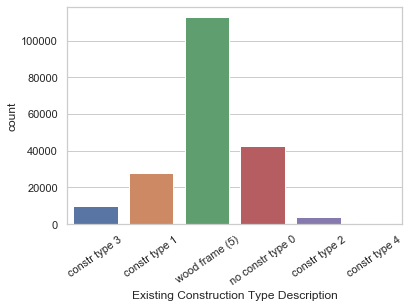

In [19]:
ax = sns.countplot(x="Existing Construction Type Description", data=sanfrancisco_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
plt.show()

Außerdem betrachten wir die `Current Status` Spalte genauer

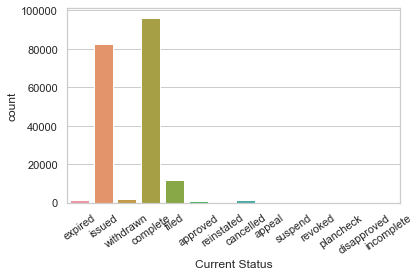

In [20]:
ax = sns.countplot(x="Current Status", data=sanfrancisco_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
plt.tight_layout()
plt.show()

Das Histogramm zeigt, dass die meisten Status `complete`, `issued`, `filed` oder `withdrawn` sind. Wir
entfernen alle anderen Spalteun und One-Hot-Encode die vier genannten. Alle Zeilen die dann keinen Status
mehr haben werden auch entfernt

In [21]:
sanfrancisco_df = pd.get_dummies(sanfrancisco_df, columns=["Current Status"])
sanfrancisco_df.drop('Current Status_appeal', axis=1, inplace=True)
sanfrancisco_df.drop('Current Status_approved', axis=1, inplace=True)
sanfrancisco_df.drop('Current Status_cancelled', axis=1, inplace=True)
sanfrancisco_df.drop('Current Status_disapproved', axis=1, inplace=True)
sanfrancisco_df.drop('Current Status_expired', axis=1, inplace=True)
sanfrancisco_df.drop('Current Status_incomplete', axis=1, inplace=True)
sanfrancisco_df.drop('Current Status_plancheck', axis=1, inplace=True)
sanfrancisco_df.drop('Current Status_reinstated', axis=1, inplace=True)
sanfrancisco_df.drop('Current Status_revoked', axis=1, inplace=True)
sanfrancisco_df.drop('Current Status_suspend', axis=1, inplace=True)

In [22]:
sanfrancisco_df = sanfrancisco_df[(sanfrancisco_df['Current Status_issued'] != 0) |
                                  (sanfrancisco_df['Current Status_complete'] != 0) |
                                  (sanfrancisco_df['Current Status_filed'] != 0) |
                                  (sanfrancisco_df['Current Status_withdrawn'] != 0)]

In [23]:
sanfrancisco_df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,...,Plansets,Existing Construction Type Description,Proposed Construction Type Description,Site Permit,Supervisor District,Record ID,Current Status_complete,Current Status_filed,Current Status_issued,Current Status_withdrawn
1,201604195146,4,sign - erect,04/19/2016,08/03/2017,04/19/2016,08/03/2017,00/00/0000,08/03/2017,0,...,2.0,constr type 3,no constr type 0,0,3.0,1420164406718,0,0,1,0
2,201605278609,3,additions alterations or repairs,05/27/2016,09/26/2017,05/27/2016,00/00/0000,00/00/0000,00/00/0000,0,...,2.0,constr type 1,constr type 1,0,3.0,1424856504716,0,0,0,1
3,201611072166,8,otc alterations permit,11/07/2016,07/24/2017,11/07/2016,07/18/2017,07/24/2017,07/18/2017,0,...,2.0,wood frame (5),wood frame (5),0,3.0,1443574295566,1,0,0,0
4,201611283529,6,demolitions,11/28/2016,12/01/2017,11/28/2016,12/01/2017,00/00/0000,11/20/2017,0,...,2.0,constr type 3,no constr type 0,0,6.0,144548169992,0,0,1,0
5,201706149344,8,otc alterations permit,06/14/2017,07/06/2017,06/14/2017,07/06/2017,00/00/0000,07/06/2017,0,...,2.0,constr type 1,constr type 1,0,10.0,1466911170855,0,0,1,0


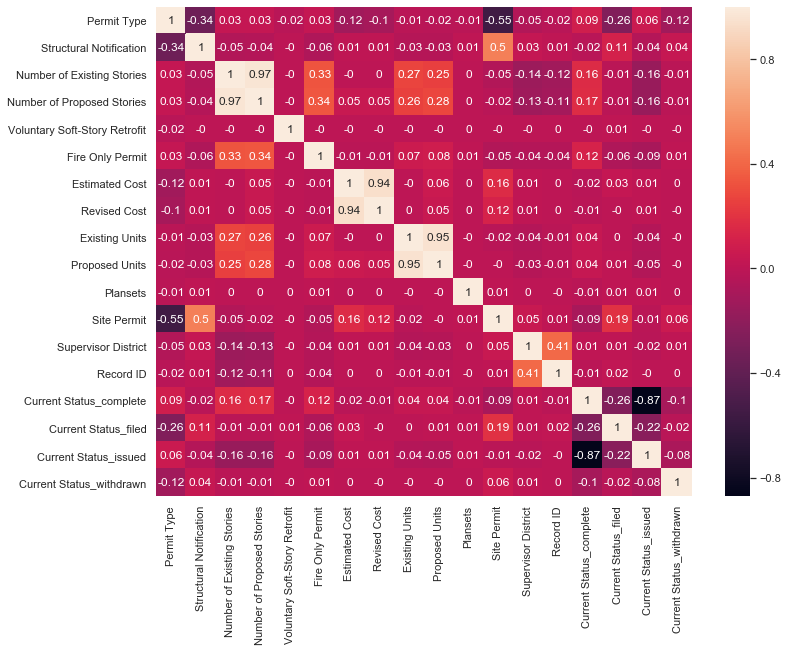

In [24]:
correlation_matrix = sanfrancisco_df.corr().round(2)
sns.set(rc={'figure.figsize':(12, 9)})
sns.heatmap(data=correlation_matrix, annot=True)

Im Hinblick auf unsere One-Hot-Codierung der aktuellen Statusspalte und das Löschen von ungewöhnlichen Werten kann das
erste Problem mit der Vorhersage des aktuellen Status gelöst werden. Jetzt haben wir Werte, bei denen wir Zusammenhänge
finden können.    
Das zweite Problem kann nicht so einfach gelöst werden: Kaum ein anderer Wert der angezeigten Werte in unserer
Korrelationsmatrix korreliert mit dem aktuellen Status. Dies kann dadurch begründet werden, dass Daten nicht mit
einbezogen sind, diese haben aber einen wesentlichen Einfluss auf den aktuellen Stand einer Baugenehmigung.
Aus diesem Grund werden wir eine bessere Spalte bauen, um die Dauer für die bearbeitung einer Genehmigung durch
Berechnung der Differenz zwischen Fälligkeitsdatum und Ausstellungsdatum vorherzusagen.

In [25]:
def days_between_dates(series):
    d1 = series["Filed Date"]
    d2 = series["Issued Date"]
    d1 = d1.split("/")
    d2 = d2.split("/")
    if len(d1) != 3 or len(d2) != 3:
        raise ValueError("Date must consist of three numbers divided by '/'")
    d1 = datetime.date(int(d1[2]), int(d1[0]), int(d1[1]))
    d2 = datetime.date(int(d2[2]), int(d2[0]), int(d2[1]))
    return (d2 - d1).days

In [26]:
sanfrancisco_df.drop("Completed Date", axis=1)
sanfrancisco_df.drop("Permit Creation Date", axis=1)

sanfrancisco_df = sanfrancisco_df[sanfrancisco_df["Issued Date"] != "00/00/0000"]
sanfrancisco_df = sanfrancisco_df[sanfrancisco_df["Filed Date"] != "00/00/0000"]

sanfrancisco_df["Processing Days"] = sanfrancisco_df.apply(days_between_dates, axis=1)

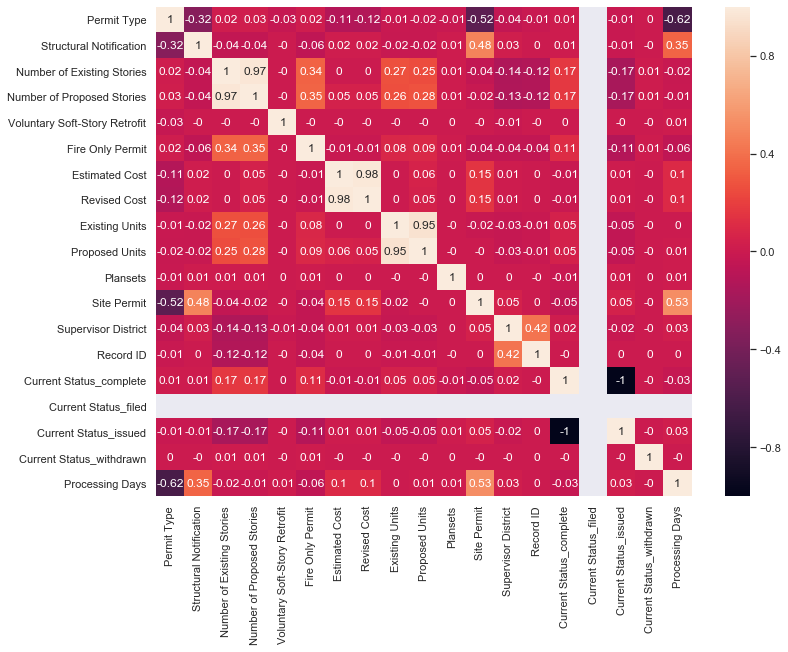

In [27]:
correlation_matrix = sanfrancisco_df.corr().round(2)
sns.set(rc={'figure.figsize':(12, 9)})
sns.heatmap(data=correlation_matrix, annot=True)

Die konstruierte Spalte `Processing Days` zeigt Zusammenhänge mit `Permit Type`, `Site Permit` und
`Structural Notification`. Allerdings sind diese nicht wirklich stark.


# C SF Permits Prediction

In [28]:
sanfrancisco_df.isnull().sum()

Permit Number                             0
Permit Type                               0
Permit Type Definition                    0
Permit Creation Date                      0
Current Status Date                       0
Filed Date                                0
Issued Date                               0
Completed Date                            0
First Construction Document Date          0
Structural Notification                   0
Number of Existing Stories                0
Number of Proposed Stories                0
Voluntary Soft-Story Retrofit             0
Fire Only Permit                          0
Permit Expiration Date                    0
Estimated Cost                            0
Revised Cost                              0
Existing Units                            0
Proposed Units                            0
Plansets                                  0
Existing Construction Type Description    0
Proposed Construction Type Description    0
Site Permit                     

We will use one-hot encoding for Permit Type Definition, Existing Construction Type Description, Proposed Construction Type Description and Supervisor District.

In [29]:
sanfrancisco_df = pd.get_dummies(sanfrancisco_df, columns=["Permit Type Definition"])
sanfrancisco_df = pd.get_dummies(sanfrancisco_df, columns=["Existing Construction Type Description"])
sanfrancisco_df = pd.get_dummies(sanfrancisco_df, columns=["Proposed Construction Type Description"])
sanfrancisco_df = pd.get_dummies(sanfrancisco_df, columns=["Supervisor District"])

In [30]:
sanfrancisco_df.isnull().sum()

Permit Number                                                 0
Permit Type                                                   0
Permit Creation Date                                          0
Current Status Date                                           0
Filed Date                                                    0
Issued Date                                                   0
Completed Date                                                0
First Construction Document Date                              0
Structural Notification                                       0
Number of Existing Stories                                    0
Number of Proposed Stories                                    0
Voluntary Soft-Story Retrofit                                 0
Fire Only Permit                                              0
Permit Expiration Date                                        0
Estimated Cost                                                0
Revised Cost                            

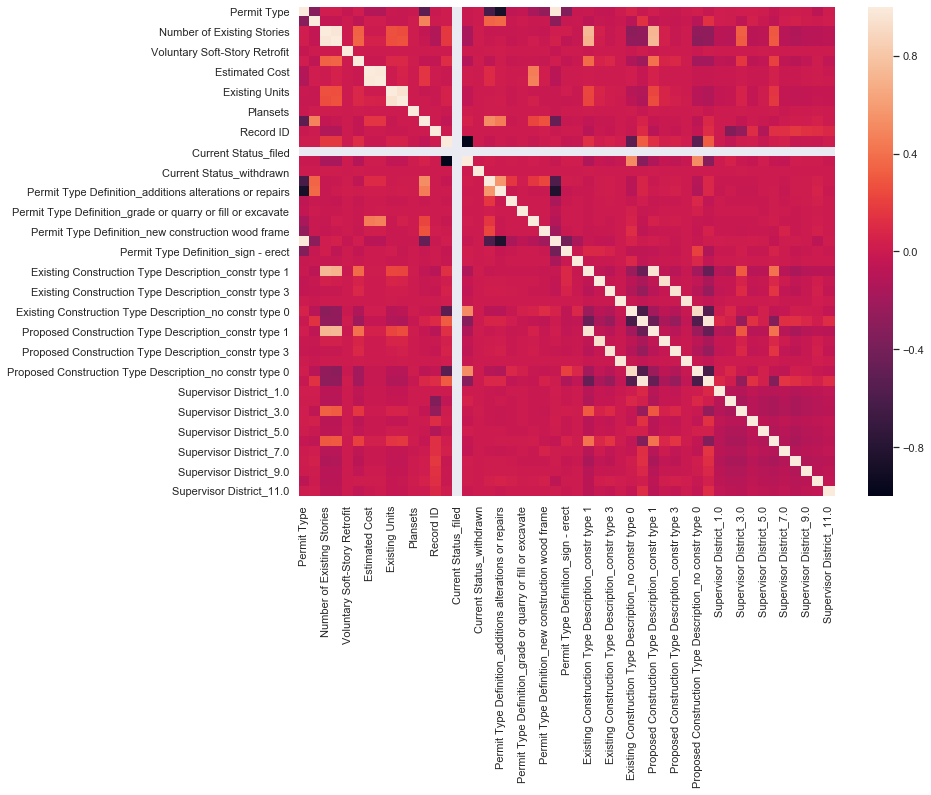

In [31]:
correlation_matrix = sanfrancisco_df.corr().round(2)
sns.set(rc={'figure.figsize':(12, 9)})
sns.heatmap(data=correlation_matrix, annot=False)

In [32]:
sanfrancisco_predictors = sanfrancisco_df.drop(['Processing Days'], axis=1)
sanfrancisco_target = sanfrancisco_df["Processing Days"]
sanfrancisco_numeric_predictors = sanfrancisco_predictors.select_dtypes(exclude=['object'])

sanfrancisco_numeric_predictors.isnull().any()

Permit Type                                                   False
Structural Notification                                       False
Number of Existing Stories                                    False
Number of Proposed Stories                                    False
Voluntary Soft-Story Retrofit                                 False
Fire Only Permit                                              False
Estimated Cost                                                False
Revised Cost                                                  False
Existing Units                                                False
Proposed Units                                                False
Plansets                                                      False
Site Permit                                                   False
Record ID                                                     False
Current Status_complete                                       False
Current Status_filed                            

## Random Forest Regressor

In [33]:
X_train, X_test, y_train, y_test = train_test_split(sanfrancisco_numeric_predictors, 
                                                    sanfrancisco_target,
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=0)

def score_dataset(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

In [34]:
print("Mean Absolute Error from dropping columns with Missing Values:")
print(score_dataset(X_train, X_test, y_train, y_test))

Mean Absolute Error from dropping columns with Missing Values:


c:\users\d074009\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


18.462121240338952


## Linear Regression

In [35]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
prediction = lin_model.predict(X_test)

In [36]:
print("Performance der Regression:")
print("--------------------------------------")
print('MSE beläuft sich auf {}'.format(mean_squared_error(y_test, prediction)))

Performance der Regression:
--------------------------------------
MSE beläuft sich auf 4093.8063760640775


# D SF Challenges

### A:
Anfangs war es nicht einfach zu entscheiden, welche Spalten man entfernen kann und welche man braucht, später war es
schwierig zu entscheiden, ob Median- oder Platzhalterwerte verwendet werden sollten, die symbolisieren, dass Werte
`null` sind.
### B:
Es war schwer, Zusammenhänge zwischen Textwerten zu finden. Da die meisten Daten im Datensatz aus Zeichenketten
bestehen, mussten viele Spalten gelöscht werden und andere konnten nicht sinnvoll verwendet werden. Darüber hinaus
erschwerten die vielen verschiedenen Werte mit nahezu gleicher Bedeutung in der Spalte `Current Status` das Auffinden
guter Zusammenhänge.
### C:
Dieselben Probleme mit Textwerten und Datumsangaben, aber hier haben wir One-Hot-Encoding verwendet.

# E Neural Networks XOR

![XOR Graph](https://github.com/maxmoehl/ATIT2_assignments/blob/master/Assignment_2/XOR.png?raw=1)

w: weight  
b: bias  
t: threshold

Mathematische Funktion:
```
SIGMOID(x) = 1 / (1 + e^(-x))
AND(x, y) = SIGMOID(50x + 50y - 75)
OR(x, y) = SIGMOID(50x + 50y - 25)
NOT(x) = SIGMOID(-50x + 10)

XOR(x, y) = AND(NOT(AND(x, y)), OR(x, y))

XOR(x,y) = SIGMOID(SIGMOID(SIGMOID(50x + 50y - 75) * (-50) + 10) * 50 + SIGMOID(50x + 50y - 25) * 50 - 75)
           \       \       \---------AND---------/             /        \                     /          /
            \       \-------------------NOT-------------------/          \--------OR---------/          /
             \-------------------------------------------AND-------------------------------------------/
```

### Funktionen in Python abbilden und testen

In [37]:
def SIGMOID(x):
    return 1 / (1 + (math.e ** (-x)))

def AND(x, y):
    return SIGMOID(x * 50 + y * 50 - 75)

def OR(x, y):
    return SIGMOID(x * 50 + y * 50 - 25)
    
def NOT(x):
    return SIGMOID(x * (-50) + 10)

def XOR(x, y):
    return AND(NOT(AND(x, y)),OR(x, y))

print(round(XOR(0, 0), 2))
print(round(XOR(0, 1), 2))
print(round(XOR(1, 0), 2))
print(round(XOR(1, 1), 2))

0.0
1.0
1.0
0.0


# F Neural Networks Overfitting

## Daten laden und splitten

Das größte Problem wenn man ein Modell hat das overfitted ist das man zu wenige Daten zum trainieren hat, um das hier
zu simulieren verwenden wir nicht die 50.000 Datensätze zum trainieren sondern nur die 10.000.

In [38]:
(X_test, Y_test), (X_train, Y_train) = datasets.cifar10.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

num_classes = 10

## Modell erstellen

Damit das Modell overfitted nehmen wir nur zwei Convolutional und ein MaxPooling Layer und zum auswerten auch nur ein
Dense Layer.

In [39]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                108170    
Total params: 127,562
Trainable params: 127,562
Non-trainable params: 0
_________________________________________________________________


## Modell trainieren

Zusätzlich trainieren wir das Modell in 20 Epochen, das Modell wird sich also viel zu sehr an die 10.000 Datensätze die
wir verwenden anpassen.

In [40]:
history = model.fit(X_train, Y_train, batch_size=100, epochs=20, validation_data=(X_test, Y_test))

Train on 10000 samples, validate on 50000 samples
Epoch 1/20
10000/10000 [==============================] - 26s 3ms/step - loss: 1.8590 - accuracy: 0.3336 - val_loss: 1.7134 - val_accuracy: 0.3917
Epoch 2/20
10000/10000 [==============================] - 25s 3ms/step - loss: 1.5278 - accuracy: 0.4587 - val_loss: 1.4946 - val_accuracy: 0.4709
Epoch 3/20
10000/10000 [==============================] - 25s 3ms/step - loss: 1.3945 - accuracy: 0.5069 - val_loss: 1.4472 - val_accuracy: 0.4888
Epoch 4/20
10000/10000 [==============================] - 25s 3ms/step - loss: 1.2768 - accuracy: 0.5476 - val_loss: 1.3822 - val_accuracy: 0.5107A: 0s - loss: 1.2733 - accuracy: 
Epoch 5/20
10000/10000 [==============================] - 25s 3ms/step - loss: 1.1734 - accuracy: 0.5871 - val_loss: 1.3349 - val_accuracy: 0.5333
Epoch 6/20
10000/10000 [==============================] - 25s 3ms/step - loss: 1.1190 - accuracy: 0.6097 - val_loss: 1.3062 - val_accuracy: 0.5409
Epoch 7/20
10000/10000 [===========

## Methode zum visualisieren der Ergebnisse

In [41]:
def plot_results(history, epoch_lim=20):
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim([0, 2.5])
  plt.xlim([0, epoch_lim])
  plt.legend(loc='upper left')

## Ergebnisse visualisieren

Train accuracy: 90.03%
Test accuracy: 55.0%


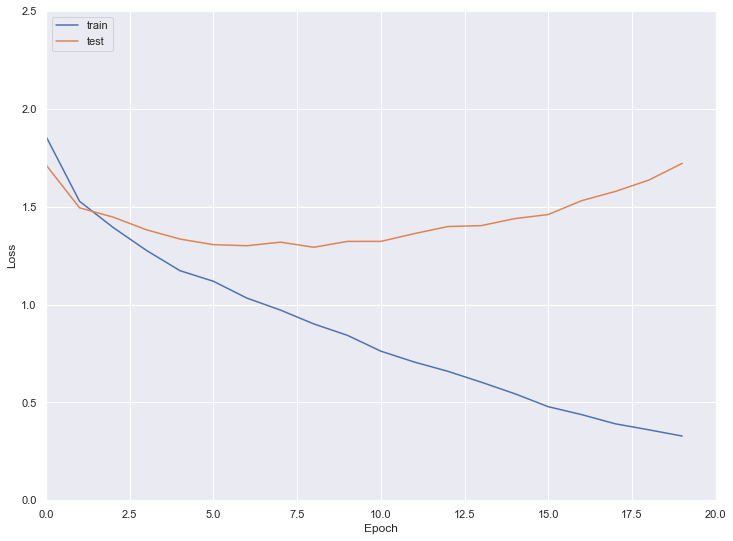

In [42]:
print("Train accuracy: {}%".format(round(history.history['accuracy'][-1] * 100, 2)))
print("Test accuracy: {}%".format(round(history.history['val_accuracy'][-1] * 100, 2)))
plot_results(history)

Wie man anhand des Graphen sehr gut sehen kann, steigt der Loss der Testdaten nach ca. 12 Epochen wieder an: das Modell
overfitted. Das kann man auch an der Accuracy sehen, für die Trainingsdaten liegt die bei über 90% währrend die
Testdaten nur um die 55% haben.

# G Neural Networks Overfitting

## Daten laden und splitten

Um jetzt in diesem Modell das Overfitting zu verhindern verwenden wir die 50.000 Datensätze zum lernen.

In [43]:
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

## Modell erstellen

Damit das Modell die Muster in den Bildern besser erkennen kann fügen wir im Vergleich zu dem ersten Modell eine
weitere Conv/MaxPooling Kombi und ein weiteres Dense Layer hinzu.

In [44]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

## Modell trainieren

Um Overfitting zu verhindern verringern wir die Anzahl an Epochen.

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
history = model.fit(X_train, Y_train, batch_size=10, epochs=15, validation_data=(X_test, Y_test), callbacks=[early_stopping])

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 92s 2ms/step - loss: 1.6400 - accuracy: 0.3955 - val_loss: 1.3093 - val_accuracy: 0.5341
Epoch 2/15
50000/50000 [==============================] - 95s 2ms/step - loss: 1.2993 - accuracy: 0.5371 - val_loss: 1.2012 - val_accuracy: 0.5713
Epoch 3/15
50000/50000 [==============================] - 89s 2ms/step - loss: 1.1537 - accuracy: 0.5916 - val_loss: 1.0767 - val_accuracy: 0.6160
Epoch 4/15
50000/50000 [==============================] - 81s 2ms/step - loss: 1.0659 - accuracy: 0.6253 - val_loss: 1.0527 - val_accuracy: 0.6347
Epoch 5/15
50000/50000 [==============================] - 73s 1ms/step - loss: 1.0008 - accuracy: 0.6514 - val_loss: 0.9732 - val_accuracy: 0.6548
Epoch 6/15
50000/50000 [==============================] - 78s 2ms/step - loss: 0.9485 - accuracy: 0.6724 - val_loss: 0.9540 - val_accuracy: 0.6653
Epoch 7/15
50000/50000 [==============================] - 75s 1ms/st

## Ergebnisse visualisieren

Train accuracy: 71.66%
Test accuracy: 68.5%


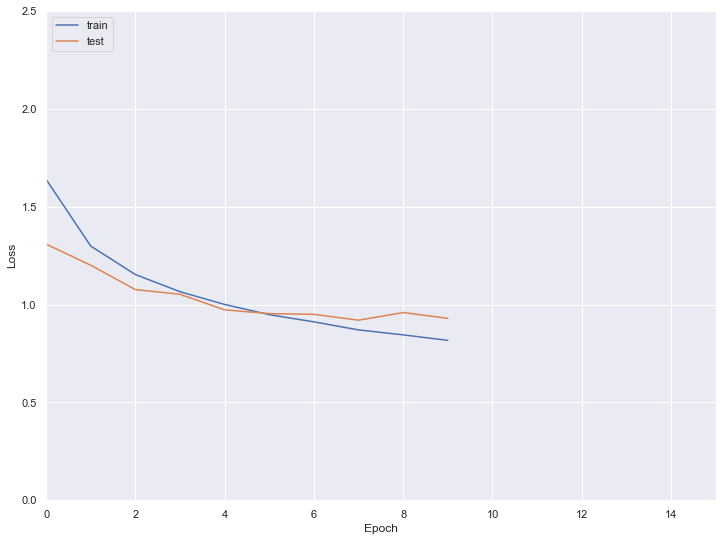

In [46]:
print("Train accuracy: {}%".format(round(history.history['accuracy'][-1] * 100, 2)))
print("Test accuracy: {}%".format(round(history.history['val_accuracy'][-1] * 100, 2)))
plot_results(history, epoch_lim=15)

Wie man an dem Graphen sehen kann sinkt der Loss sowohl für die Trainingsdaten als auch für die Testdaten
kontinuierlich. Das Modell generalisiert wesentlich besser anstatt einfach nur die Bilder aus dem Trainingsset
auswendig zu lernen. Der Early-Stop Callback verhindert, dass das Modell durch zu viele Trainingsepochen overfitted.  
Die Accuracy von Train und Test liegen auch sehr nah beieinander.

# H Feedback
### Wieviel Zeit habt ihr mit dem Assignment verbracht?
Fabian: 14h  
Felix: 4h  
Max: 15h
### Wie oft habt ihr euch getroffen?
4
### Welche Aufgabe hat euch am besten gefallen?
E
### Welche Aufgabe hat euch am wenigsten gefallen?
C